In [9]:
import os
import json
import numpy as np
from collections import defaultdict
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset #load_dataset from Huggingface
from scipy import stats

In [10]:
LANG_DICT = {'arabic': 'ar', 
                 'english': 'en', 
                 'spanish': 'es',
                 'basque': 'eu',
                 'indonesian': 'id',
                 'burmese': 'my',
                 'russian': 'ru',
                 'telugu': 'te',
                 'chinese': 'zh',
                 'swahili': 'sw',
                 'hindi': 'hi'}

LANGUAGE = ['arabic', 'spanish', 'basque', 'hindi', 'indonesian', 'burmese', 'russian', 'telugu', 'chinese', 'swahili']
INPUT_FIELD = ['input_sentence_1', 'input_sentence_2', 'input_sentence_3', 'input_sentence_4', 'sentence_quiz1', 'sentence_quiz2']

In [39]:
def get_accuracy_outputs(lang, dataset='xstorycloze', model='Llama3.1', mode='normalized', shot=0):
    model_dict = {'Llama3.1': 'meta-llama__Llama-3.1-8B'}
    lang_code = LANG_DICT[lang]
    model_code = model_dict[model]
    if dataset == 'xstorycloze':
        hf = load_dataset("juletxara/xstory_cloze", lang_code)
        answer_right_ending = hf['eval']['answer_right_ending']
        answer = []
        for i in range(len(answer_right_ending)):
            answer.append(answer_right_ending[i])
    
    if mode == 'normalized':
        accuracy_data_path = f'../accuracy_outputs/{model}/{dataset}_normalized_{shot}shot/{lang_code}/{model_code}/'
    else:
        accuracy_data_path = f'../accuracy_outputs/{model}/{dataset}_unnormalized_{shot}shot/{lang_code}/{model_code}/'
    # Find the .jsonl file in the directory
    jsonl_file = [f for f in os.listdir(accuracy_data_path) if f.endswith('.jsonl')][0]
    file_path = os.path.join(accuracy_data_path, jsonl_file)
    # Read the jsonl file line by line
    accuracy_results = []
    with open(file_path, 'r') as f:
        for line in f:
            accuracy_results.append(json.loads(line))

    resps = [item['resps'] for item in accuracy_results]
    accuracy = [item['acc'] for item in accuracy_results]
    score_diff = []
    for i in range(len(answer)):
        if answer[i]==1:
            score_diff.append(float(resps[i][0][0][0]) - float(resps[i][1][0][0]))
        if answer[i]==2:
            score_diff.append(float(resps[i][1][0][0]) - float(resps[i][0][0][0]))
    return score_diff, accuracy

In [40]:
def compute_confusion_matrix(correct_eng, incorrect_eng, correct_lang, incorrect_lang):
    TP = len(set(correct_eng) & set(correct_lang))
    FN = len(set(incorrect_eng) & set(correct_lang))
    FP = len(set(correct_eng) & set(incorrect_lang))
    TN = len(set(incorrect_eng) & set(incorrect_lang))
    
    return np.array([[TP, FN], [FP, TN]])

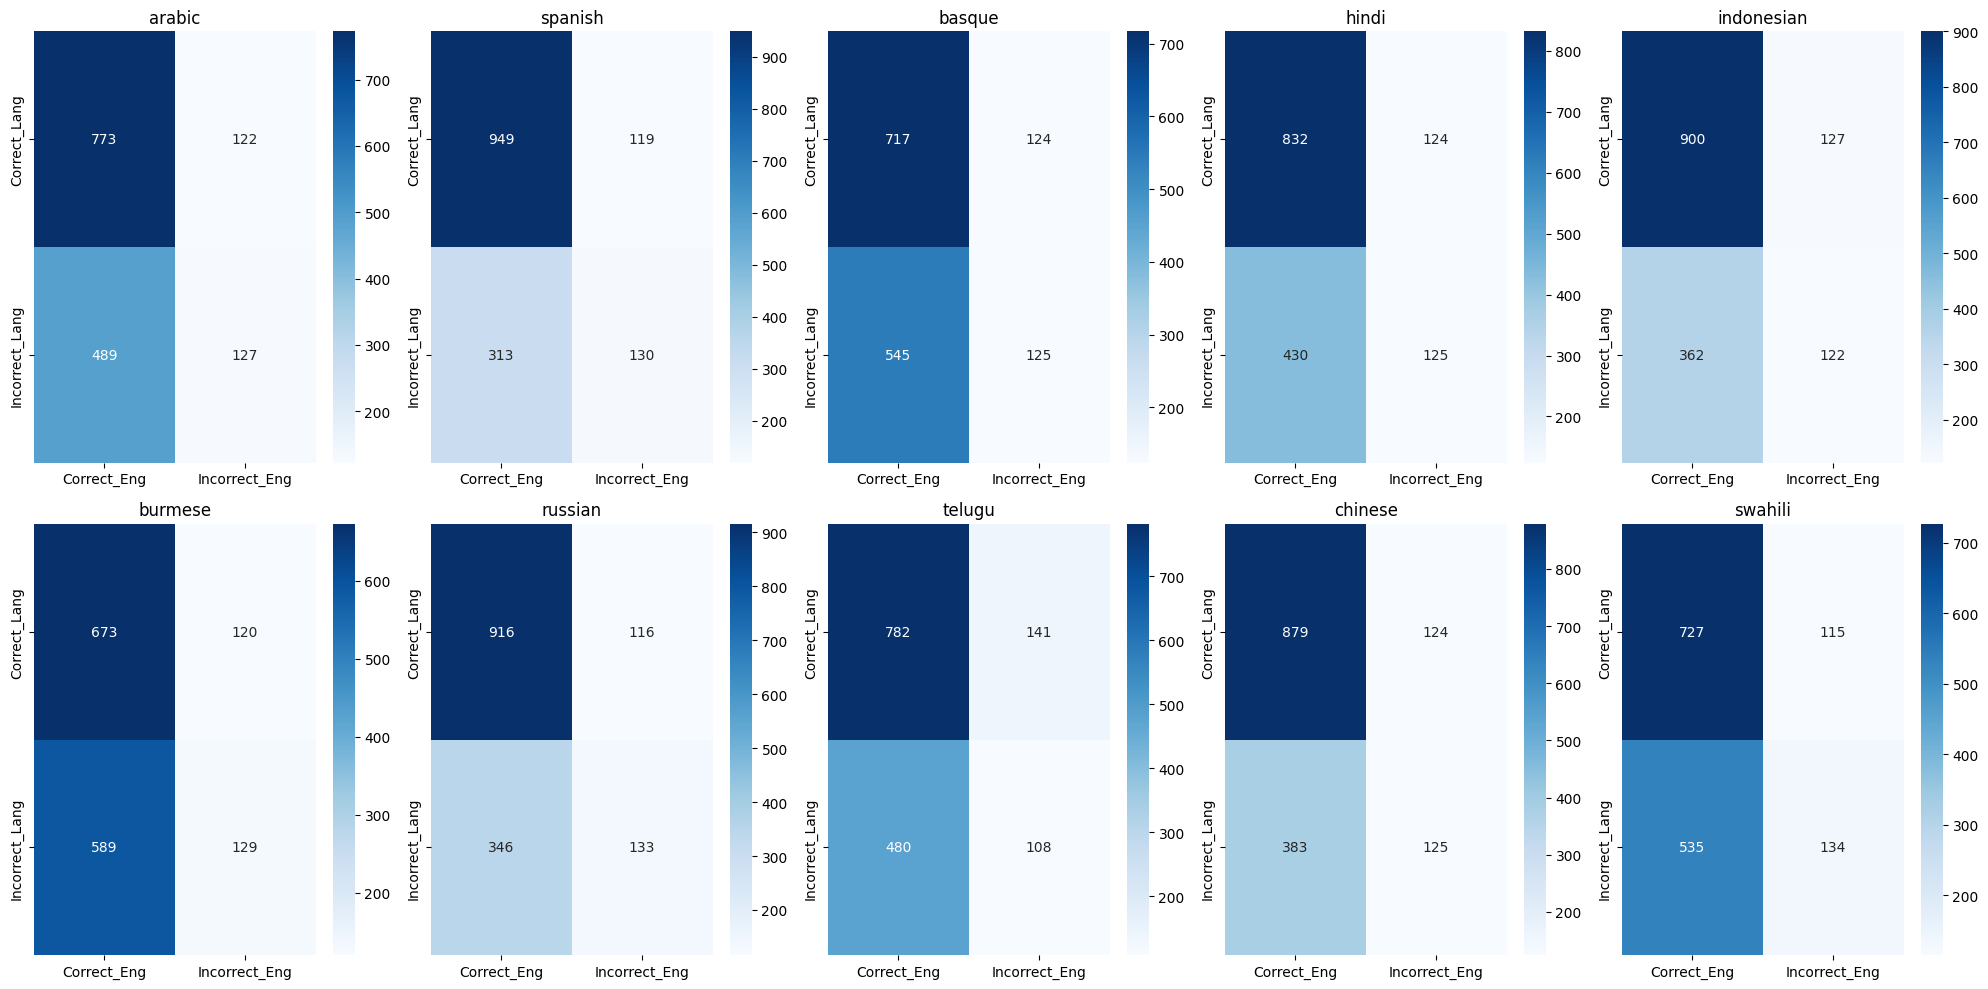

In [68]:
acc_dict = defaultdict(dict)
score_diff_dict = defaultdict(dict)

conf_matrices = defaultdict(dict)

score_diff_dict['english'], acc_dict['english'] = get_accuracy_outputs('english', 'xstorycloze', 'Llama3.1')

for lang in LANGUAGE:
    score_diff_dict[lang],acc_dict[lang]  = get_accuracy_outputs(lang, 'xstorycloze', 'Llama3.1', mode='unnormalized', shot=0)
    correct_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==1]
    incorrect_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==0]
       
    correct_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==1]
    incorrect_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==0]

    # Example language data (Replace with actual lists)
    conf_matrices[lang] = compute_confusion_matrix(correct_id_eng, incorrect_id_eng, correct_id_lang, incorrect_id_lang)
    
    correct_eng_incorrect_lang_ids = list(set(correct_id_eng) & set(incorrect_id_lang))
    correct_eng_correct_lang_ids = list(set(correct_id_eng) & set(correct_id_lang))

# Plot multiple confusion matrices
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 rows, 5 columns

for ax, (lang, matrix) in zip(axes.flat, conf_matrices.items()):
    
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Correct_Eng", "Incorrect_Eng"], 
                yticklabels=["Correct_Lang", "Incorrect_Lang"], ax=ax)
    ax.set_title(lang)

    plt.tight_layout()
plt.show()   

In [72]:
def plot_DALI(dataset, lang, model):
    DAS_path = f'../alignment_outputs/{model}/{dataset}_dali_strict/DALI_{lang}_lasttoken.json'
    with open(DAS_path) as f:
        lang_DAS = json.load(f)
    return lang_DAS

In [7]:
def plot_MEXA(dataset, lang, model):
    MEXA_path = f'../alignment_outputs/{model}/{dataset}_mexa/{lang}.json'

    with open(MEXA_path) as f:
        lang_MEXA = json.load(f)
    return lang_MEXA

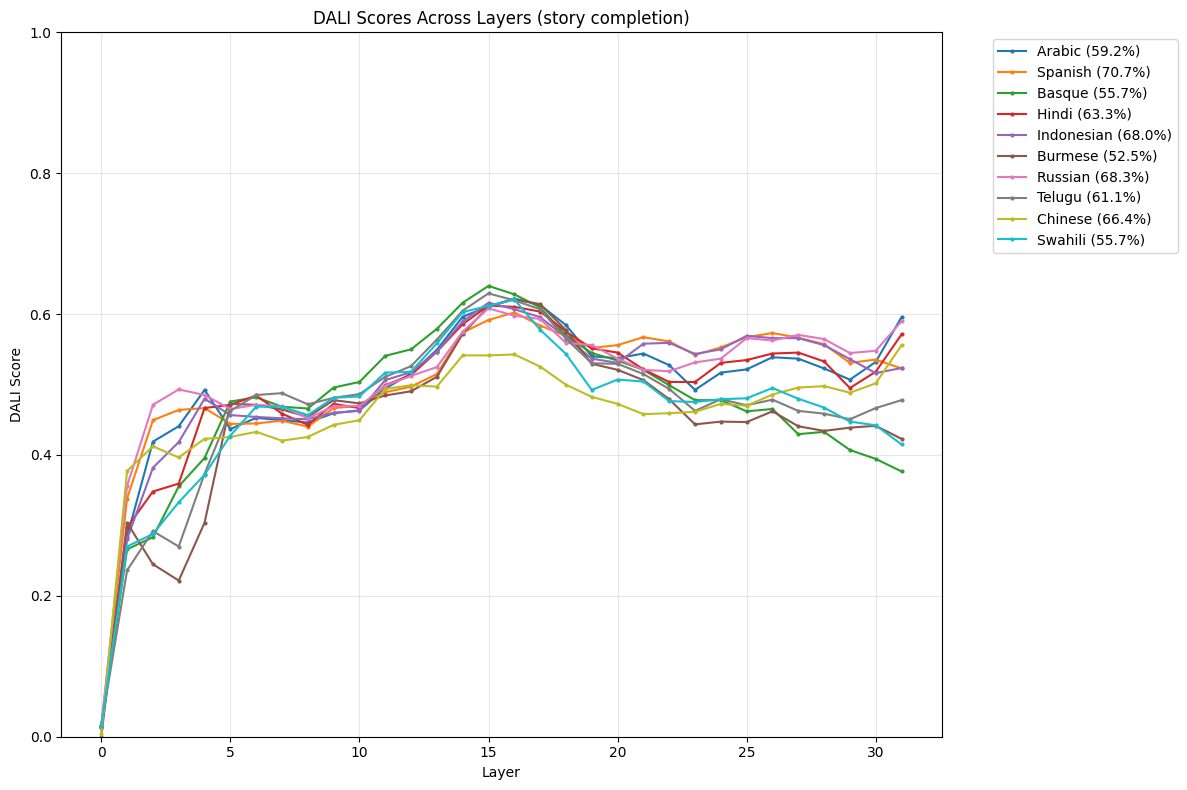


Languages ranked by maximum DALI score:
1. Russian: 0.507
2. Spanish: 0.502
3. Indonesian: 0.499
4. Arabic: 0.496
5. Hindi: 0.491
6. Telugu: 0.468
7. Basque: 0.468
8. Swahili: 0.462
9. Chinese: 0.458
10. Burmese: 0.449


In [76]:
# Calculate accuracies and get DAS scores for each language
accuracies = {}
max_das_scores = {}
all_das_avgs = {}

fig, ax = plt.subplots(figsize=(12, 8))

for lang in LANGUAGE:
    # Calculate accuracy
    accuracies[lang] = (sum(acc_dict[lang])/len(acc_dict[lang])) * 100
    # Get DAS data for this language
    lang_DAS = plot_DALI('xstorycloze', lang, 'Llama3.1')
    
    lang_DAS = {int(outer_k): {int(inner_k): v for inner_k, v in inner_v.items()} 
                for outer_k, inner_v in lang_DAS.items()}
    
    
    # Calculate average DAS across all samples for each layer
    layer_avgs = []
    for layer in range(32):
        layer_scores = [lang_DAS[sample][layer] for sample in lang_DAS.keys()]
        layer_avgs.append(np.mean(layer_scores))
    
    all_das_avgs[lang] = layer_avgs
    max_das_scores[lang] = np.mean(layer_avgs)
    
    # Plot line with accuracy in legend
    ax.plot(range(32), layer_avgs, 
            label=f'{lang.capitalize()} ({accuracies[lang]:.1f}%)', 
            marker='o', markersize=2)

ax.set_xlabel('Layer')
ax.set_ylabel('DALI Score')
ax.set_title('DALI Scores Across Layers (story completion)')
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0,1)

plt.tight_layout()
plt.show()

# Rank languages by maximum DAS score
ranked_languages = sorted(max_das_scores.items(), key=lambda x: x[1], reverse=True)
print("\nLanguages ranked by maximum DALI score:")
for i, (lang, score) in enumerate(ranked_languages, 1):
    print(f"{i}. {lang.capitalize()}: {score:.3f}")

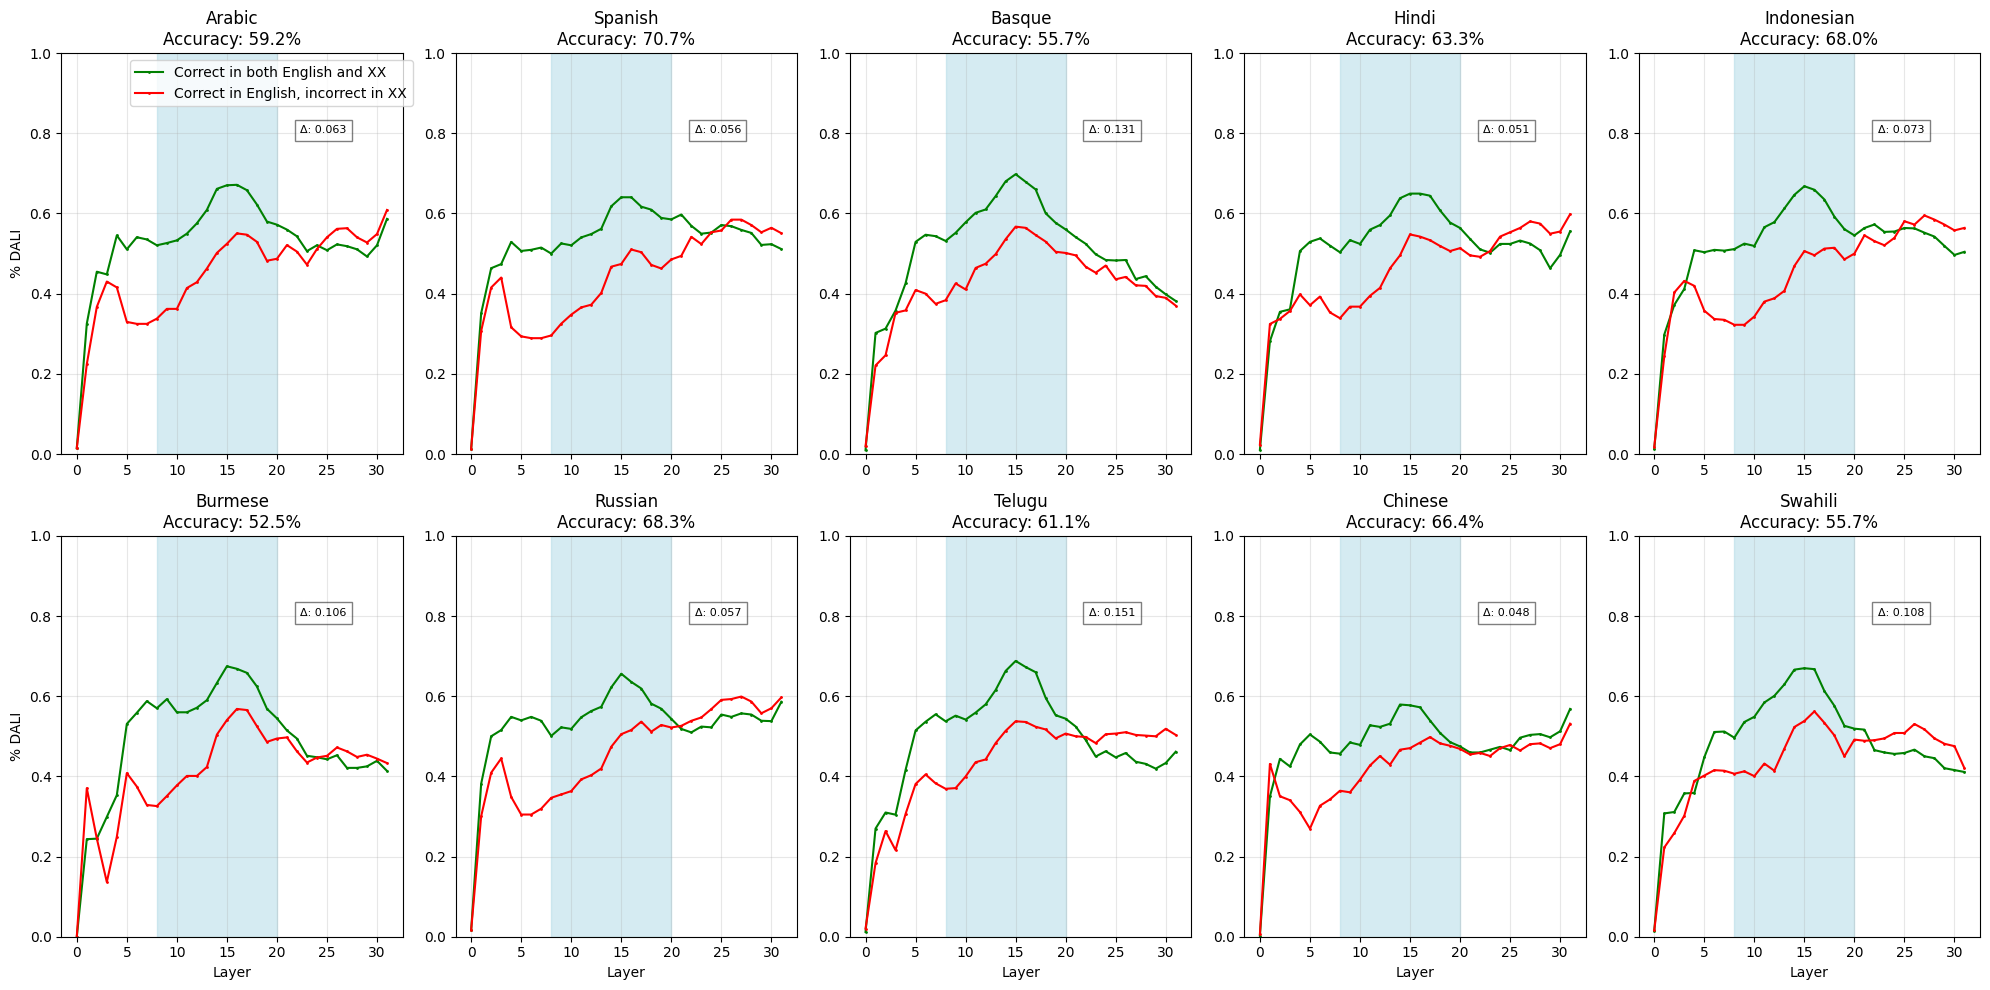

In [78]:
# Calculate accuracies for each language
from statsmodels.stats.weightstats import ztest

accuracies = {lang: (sum(acc_dict[lang])/len(acc_dict[lang])) * 100 for lang in LANGUAGE}

# Create a figure with subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# Flatten axes for easier iteration
axes = axes.flatten()

for idx, (lang, ax) in enumerate(zip(LANGUAGE, axes)):
    # Get accuracy data for this language
    correct_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==1]
    incorrect_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==0]
    correct_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==1]
    incorrect_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==0]
    
    correct_eng_incorrect_lang_ids = list(set(correct_id_eng) & set(incorrect_id_lang))
    correct_eng_correct_lang_ids = list(set(correct_id_eng) & set(correct_id_lang))
    incorrect_eng_correct_lang_ids = list(set(incorrect_id_eng) & set(correct_id_lang))
    incorrect_eng_incorrect_lang_ids = list(set(incorrect_id_eng) & set(incorrect_id_lang))

    
    # Get DAS data for this language
    lang_DAS = plot_DALI('xstorycloze', lang, 'Llama3.1')
    lang_DAS = {int(outer_k): {int(inner_k): v for inner_k, v in inner_v.items()} 
                for outer_k, inner_v in lang_DAS.items()}

    # Calculate averages for both cases
    correct_list = defaultdict(list)
    incorrect_list = defaultdict(list)

    for item in correct_id_lang:
        for layer in range(32):
            correct_list[layer].append(lang_DAS[item][layer])

    for item in incorrect_id_lang:
        for layer in range(32):
            incorrect_list[layer].append(lang_DAS[item][layer])
        
    correct_mean = []
    incorrect_mean = []

    for k,v in correct_list.items():
        correct_mean.append(np.mean(v))

    for k,v in incorrect_list.items():
        incorrect_mean.append(np.mean(v))

    max_index_correct = np.argmax(correct_mean)
    max_index_incorrect = np.argmax(incorrect_mean)

    
        
    delta = correct_mean[max_index_correct] - incorrect_mean[max_index_incorrect]
    z, p_value = ztest(correct_list[max_index_correct], incorrect_list[max_index_incorrect], alternative="larger")



    # Plot lines for this language
    layers = list(range(32))
    ax.plot(layers, [correct_mean[l] for l in layers], 
            label='Correct in both English and XX', marker='o', color='green', markersize=1)
    ax.plot(layers, [incorrect_mean[l] for l in layers], 
            label='Correct in English, incorrect in XX', color = 'red', marker='o', markersize=1)
    
    
    annotation_text = f'Δ: {delta:.3f}'
    ax.annotate(annotation_text, xy=(0.7, 0.8), xycoords='axes fraction', fontsize=8,
                bbox=dict(facecolor='white', alpha=0.5))
    
    ax.set_ylim(0,1)
    
    # Add title with accuracy
    ax.set_title(f'{lang.capitalize()}\nAccuracy: {accuracies[lang]:.1f}%')
    ax.grid(True, alpha=0.3)
    ax.axvspan(8, 20, color='lightblue', alpha=0.5)
    
    # Only add x and y labels for the bottom row and leftmost column
    if idx >= 5:  # Bottom row
        ax.set_xlabel('Layer')
    if idx % 5 == 0:  # Leftmost column
        ax.set_ylabel('% DALI')
    
    # Add legend only for the first subplot
    if idx == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper right')

plt.tight_layout()
plt.show()

In [35]:
# Flatten axes for easier iteration
axes = axes.flatten()

DALI_max_layer = defaultdict(list)

for idx, (lang, ax) in enumerate(zip(LANGUAGE, axes)):
    accuracies[lang] = (sum(acc_dict[lang])/len(acc_dict[lang])) * 100
    # Get DAS data for this language
    lang_DAS = plot_DALI('xstorycloze', lang, 'Llama3.1')
    
    lang_DAS = {int(outer_k): {int(inner_k): v for inner_k, v in inner_v.items()} 
                for outer_k, inner_v in lang_DAS.items()}
    
    # Calculate average DAS across all samples for each layer
    layer_avgs = []
    for layer in range(32):
        layer_scores = [lang_DAS[sample][layer] for sample in lang_DAS.keys()]
        layer_avgs.append(np.mean(layer_scores))
    
    max_layer_idx = np.argmax(layer_avgs)

    # Get DALI for all samples in max_layer_idx

    DALI_max_layer[lang] = [lang_DAS[sample][max_layer_idx] for sample in lang_DAS.keys()]
    positive_DALI_idx = [i for i,dali in enumerate(DALI_max_layer[lang]) if dali==1]
    negative_DALI_idx = [i for i,dali in enumerate(DALI_max_layer[lang]) if dali==0]

    positive_DALI_acc = [acc_dict[lang][i] for i in positive_DALI_idx]
    negative_DALI_acc = [acc_dict[lang][i] for i in negative_DALI_idx]

    positive_DALI_conf = [score_diff_dict[lang][i] for i in positive_DALI_idx]
    negative_DALI_conf = [score_diff_dict[lang][i] for i in negative_DALI_idx]

    z, p_value_acc = ztest(positive_DALI_acc, negative_DALI_acc, alternative="larger")

    print(f'{lang}, acc-p-value: {np.mean(positive_DALI_acc)- np.mean(negative_DALI_acc)}, {p_value_acc}')



arabic, acc-p-value: -0.061330775219664124, 0.9785599798067681
spanish, acc-p-value: -0.016282309240055803, 0.6433670815972712
basque, acc-p-value: 0.01514647137150471, 0.27246198372619
hindi, acc-p-value: -0.017681180673518426, 0.7561520309498126
indonesian, acc-p-value: -0.03456790123456799, 0.8677410937268821
burmese, acc-p-value: -0.05348569969356487, 0.9122165237465544
russian, acc-p-value: -0.04247027613183074, 0.8813126661018034
telugu, acc-p-value: -0.058667397544826416, 0.9788670474159749
chinese, acc-p-value: 0.038647817780119054, 0.12052071579722451
swahili, acc-p-value: 0.0022735479618702925, 0.46343254523510424


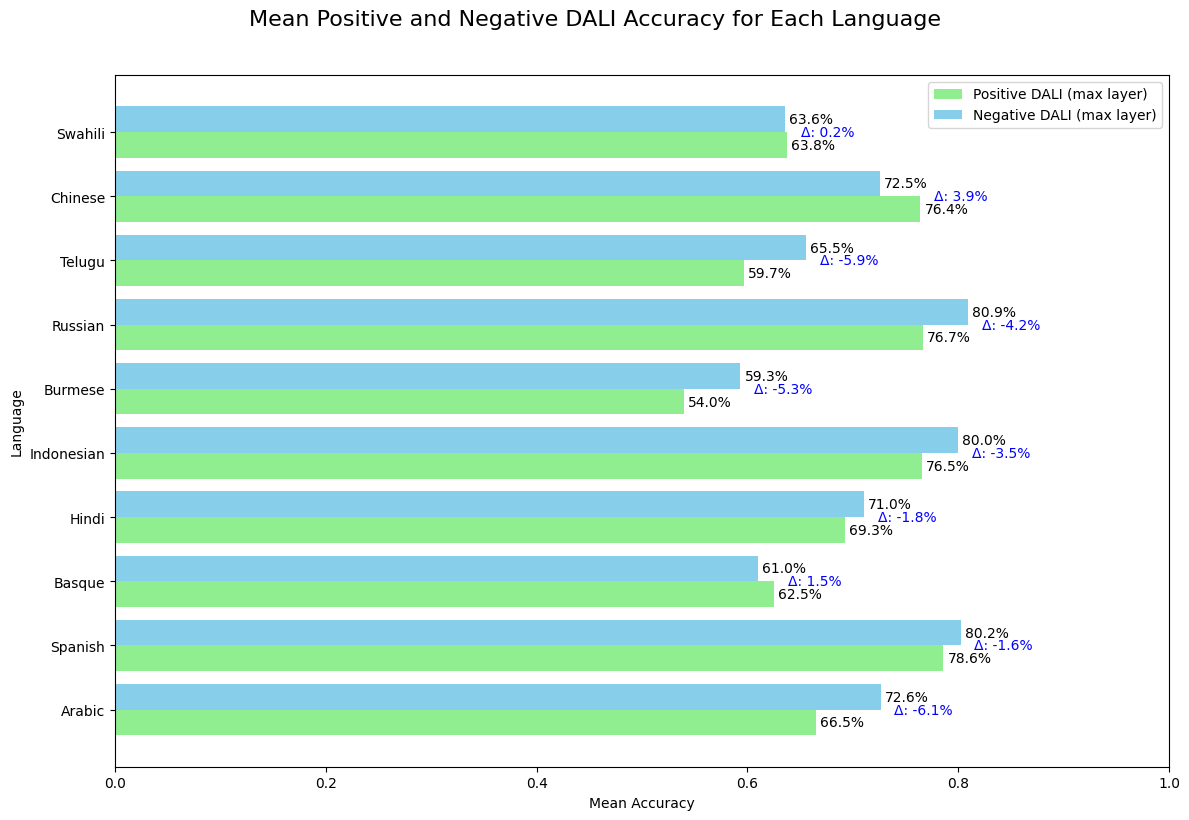

In [36]:
# Create a figure
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle('Mean Positive and Negative DALI Accuracy for Each Language', fontsize=16, y=1.02)

languages = []
positive_accuracies = []
negative_accuracies = []
deltas = []

for lang in LANGUAGE:
    # Get positive and negative DALI accuracies
    positive_DALI_idx = [i for i, dali in enumerate(DALI_max_layer[lang]) if dali == 1]
    negative_DALI_idx = [i for i, dali in enumerate(DALI_max_layer[lang]) if dali == 0]

    positive_DALI_acc = [acc_dict[lang][i] for i in positive_DALI_idx]
    negative_DALI_acc = [acc_dict[lang][i] for i in negative_DALI_idx]

    mean_positive_DALI_acc = np.mean(positive_DALI_acc)
    mean_negative_DALI_acc = np.mean(negative_DALI_acc)
    delta = mean_positive_DALI_acc - mean_negative_DALI_acc

    languages.append(lang.capitalize())
    positive_accuracies.append(mean_positive_DALI_acc)
    negative_accuracies.append(mean_negative_DALI_acc)
    deltas.append(delta)

# Plot horizontal bar chart
bar_width = 0.4
y_pos = np.arange(len(languages))

ax.barh(y_pos - bar_width/2, positive_accuracies, bar_width, label='Positive DALI (max layer)', color='lightgreen')
ax.barh(y_pos + bar_width/2, negative_accuracies, bar_width, label='Negative DALI (max layer)', color='skyblue')

# Annotate individual accuracies and deltas
for i in range(len(languages)):
    ax.annotate(f'{positive_accuracies[i]*100:.1f}%', xy=(positive_accuracies[i], y_pos[i] - bar_width/2),
                xytext=(3, 0), textcoords='offset points', ha='left', va='center', fontsize=10, color='black')
    ax.annotate(f'{negative_accuracies[i]*100:.1f}%', xy=(negative_accuracies[i], y_pos[i] + bar_width/2),
                xytext=(3, 0), textcoords='offset points', ha='left', va='center', fontsize=10, color='black')
    ax.annotate(f'Δ: {deltas[i]*100:.1f}%', xy=(max(positive_accuracies[i], negative_accuracies[i]), y_pos[i]),
                xytext=(10, 0), textcoords='offset points', ha='left', va='center', fontsize=10, color='blue')

ax.set_yticks(y_pos)
ax.set_yticklabels(languages)
ax.set_xlabel('Mean Accuracy')
ax.set_ylabel('Language')
ax.set_xlim(0, 1)
ax.legend()

plt.tight_layout()
plt.show()

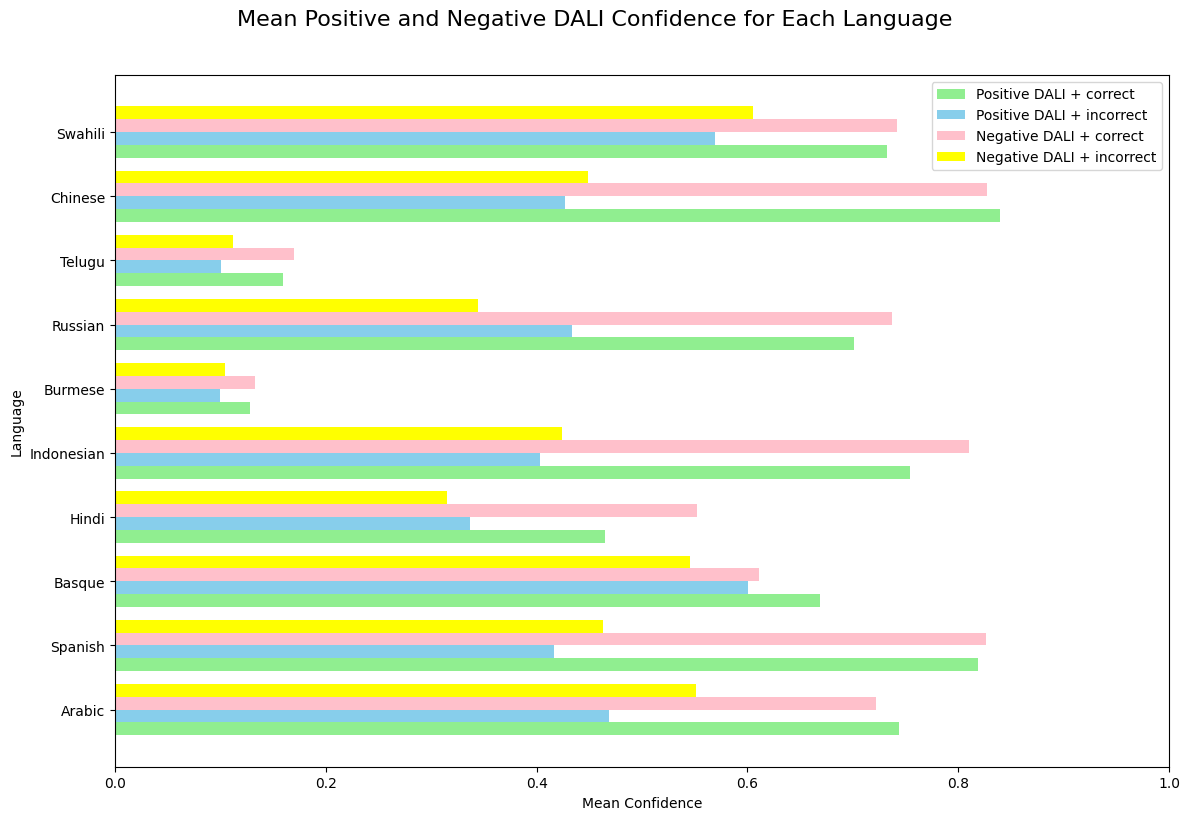

In [37]:
# Create a figure
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle('Mean Positive and Negative DALI Confidence for Each Language', fontsize=16, y=1.02)

languages = []
positive_correct_confidences = []
negative_correct_confidences = []
positive_incorrect_confidences = []
negative_incorrect_confidences = []

deltas = []

for lang in LANGUAGE:
    accuracy = acc_dict[lang]
    correct_id = [i for i, acc_flag in enumerate(accuracy) if acc_flag == 1]
    wrong_id = [i for i, acc_flag in enumerate(accuracy) if acc_flag == 0]

    correct_and_positive_DALI_idx = list(set(correct_id) & set(positive_DALI_idx))
    correct_and_negative_DALI_idx = list(set(correct_id) & set(negative_DALI_idx))
    incorrect_and_positive_DALI_idx = list(set(wrong_id) & set(positive_DALI_idx))
    incorrect_and_negative_DALI_idx = list(set(wrong_id) & set(negative_DALI_idx))
    
    correct_positive_DALI_conf = [score_diff_dict[lang][i] for i in correct_and_positive_DALI_idx]
    correct_negative_DALI_conf = [score_diff_dict[lang][i] for i in correct_and_negative_DALI_idx]
    incorrect_positive_DALI_conf = [score_diff_dict[lang][i] for i in incorrect_and_positive_DALI_idx]
    incorrect_negative_DALI_conf = [score_diff_dict[lang][i] for i in incorrect_and_negative_DALI_idx]

    # Get positive and negative DALI confidences
    mean_correct_positive_DALI_conf = np.mean(correct_positive_DALI_conf)
    mean_correct_negative_DALI_conf = np.mean(correct_negative_DALI_conf)
    mean_incorrect_positive_DALI_conf = np.mean(incorrect_positive_DALI_conf)
    mean_incorrect_negative_DALI_conf = np.mean(incorrect_negative_DALI_conf)

    languages.append(lang.capitalize())
    positive_correct_confidences.append(abs(mean_correct_positive_DALI_conf))
    positive_incorrect_confidences.append(abs(mean_incorrect_positive_DALI_conf))
    negative_correct_confidences.append(abs(mean_correct_negative_DALI_conf))
    negative_incorrect_confidences.append(abs(mean_incorrect_negative_DALI_conf))

    

# Plot horizontal bar chart
bar_width = 0.2
y_pos = np.arange(len(languages))

ax.barh(y_pos - 1.5 * bar_width, positive_correct_confidences, bar_width, label='Positive DALI + correct', color='lightgreen')
ax.barh(y_pos - 0.5 * bar_width, positive_incorrect_confidences, bar_width, label='Positive DALI + incorrect', color='skyblue')
ax.barh(y_pos + 0.5 * bar_width, negative_correct_confidences, bar_width, label='Negative DALI + correct', color='pink')
ax.barh(y_pos + 1.5 * bar_width, negative_incorrect_confidences, bar_width, label='Negative DALI + incorrect', color='yellow')

ax.set_yticks(y_pos)
ax.set_yticklabels(languages)
ax.set_xlabel('Mean Confidence')
ax.set_ylabel('Language')
ax.set_xlim(0, 1)
ax.legend()

plt.tight_layout()
plt.show()

In [22]:
all_data = []

# Iterate over each language
for lang in LANGUAGE:
    print(lang)
    accuracy = acc_dict[lang]
    score_diff = score_diff_dict[lang]
    score_diff_eng =score_diff_dict['english'] 
    accuracy_eng = acc_dict['english']
    correct_id_lang = [i for i, acc_flag in enumerate(accuracy) if acc_flag == 1]
    wrong_id_lang = [i for i, acc_flag in enumerate(accuracy) if acc_flag == 0]

    correct_id_eng = [i for i, acc_flag in enumerate(accuracy_eng) if acc_flag == 1]
    wrong_id_eng = [i for i, acc_flag in enumerate(accuracy_eng) if acc_flag == 0]

    correct_XX_correct_eng = list(set(correct_id_eng) & set(correct_id_lang))
    wrong_XX_correct_eng = list(set(correct_id_eng) & set(wrong_id_lang))
    wrong_XX_wrong_eng = list(set(wrong_id_eng) & set(wrong_id_lang))
    correct_XX_wrong_eng = list(set(wrong_id_eng) & set(correct_id_lang))

    DALI = plot_DALI('xstorycloze', lang, 'Llama3.1')
        
    DALI = {int(outer_k): {int(inner_k): v for inner_k, v in inner_v.items()} 
                for outer_k, inner_v in DALI.items()}


    DALI_layers = [[] for i in range(32)]
    DALI_avg = [0 for i in range(32)]
    for layer in range(32):
        layer_scores = [DALI[sample][layer] for sample in DALI.keys()]
        DALI_layers[layer] = layer_scores
        DALI_avg[layer] = np.average(DALI_layers[layer])

        
    maxDALI_idx = np.argmax(DALI_avg)
    
    #print(lang)
    #print(maxDALI_idx)

    result_idx = defaultdict(list)
    
    for layer in range(maxDALI_idx,32,1):
        maxDALI = DALI_layers[layer]
        maxDALI_aligned_idx = [i for i,dali in enumerate(maxDALI) if dali==1]
        maxDALI_nonaligned_idx = [i for i,dali in enumerate(maxDALI) if dali==0]

        maxDALI_aligned_correct_XX_correct_eng = list(set(correct_XX_correct_eng) & set(maxDALI_aligned_idx))
        maxDALI_aligned_wrong_XX_correct_eng = list(set(wrong_XX_correct_eng) & set(maxDALI_aligned_idx))
        maxDALI_aligned_wrong_XX_wrong_eng = list(set(wrong_XX_wrong_eng) & set(maxDALI_aligned_idx))
        maxDALI_aligned_correct_XX_wrong_eng = list(set(correct_XX_wrong_eng) & set(maxDALI_aligned_idx))
        maxDALI_nonaligned_correct_XX_correct_eng = list(set(correct_XX_correct_eng) & set(maxDALI_nonaligned_idx))
        maxDALI_nonaligned_wrong_XX_correct_eng = list(set(wrong_XX_correct_eng) & set(maxDALI_nonaligned_idx))
        maxDALI_nonaligned_wrong_XX_wrong_eng = list(set(wrong_XX_wrong_eng) & set(maxDALI_nonaligned_idx))
        maxDALI_nonaligned_correct_XX_wrong_eng = list(set(correct_XX_wrong_eng) & set(maxDALI_nonaligned_idx))
        result_idx[layer] = [maxDALI_aligned_correct_XX_correct_eng, 
                    maxDALI_nonaligned_correct_XX_correct_eng, 
                    maxDALI_aligned_wrong_XX_correct_eng, 
                    maxDALI_nonaligned_wrong_XX_correct_eng,
                    maxDALI_aligned_wrong_XX_wrong_eng,
                    maxDALI_nonaligned_wrong_XX_wrong_eng,
                    maxDALI_aligned_correct_XX_wrong_eng,
                    maxDALI_nonaligned_correct_XX_wrong_eng]

# Calculate length, mean confidence, and standard deviation for each list
        for lst in result_idx[layer]:
            length = len(lst)
            mean_conf = np.mean([abs(score_diff[item]) for item in lst])
            std_conf = np.std([abs(score_diff[item]) for item in lst])
            mean_conf_eng = np.mean([abs(score_diff_eng[item]) for item in lst])
            std_conf_eng = np.std([abs(score_diff_eng[item]) for item in lst])
            all_data.append([lang, layer, length, mean_conf, std_conf, mean_conf_eng, std_conf_eng])
        

# Create DataFrame
df_all_languages = pd.DataFrame(all_data, columns=['Language', 'Layer', 'Length', 'Mean Confidence_lang', 'SD_lang', 'Mean Confidence_eng', 'SD_eng'])
df_all_languages.to_csv('maxDALIlayer.csv', index=False)


arabic
spanish
basque
hindi
indonesian
burmese
russian
telugu
chinese
swahili
